In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.optimize import minimize

mpl.rc('font', family = 'Gulim')
mpl.rcParams['axes.unicode_minus']=False

In [2]:
a = pd.read_csv("Project_week.csv", encoding = "euc-kr")

# 인구

In [3]:
# 총인구
b = pd.read_csv("Projecti_population.csv", encoding = "euc-kr")

b = b.transpose()
b.columns = ["전국","서울","부산","대구","인천","광주","대전","울산","세종","경기","강원","충북","충남",
            "전북","전남","경북","경남","제주"]
b =b.iloc[1:]
b = b.astype(int)
b = (b/10000).astype(int)

b_des = b.describe()

population = b_des.iloc[5].astype(int)
population = population * 10000

In [4]:
population

전국    51660000
서울     9530000
부산     3350000
대구     2390000
인천     2950000
광주     1440000
대전     1450000
울산     1120000
세종      360000
경기    13540000
강원     1530000
충북     1590000
충남     2110000
전북     1780000
전남     1830000
경북     2620000
경남     3310000
제주      670000
Name: 50%, dtype: int32

# 전국

In [5]:
# 데이터 추출
a1 = a.iloc[:,[0,1,19]]

In [6]:
# S,E,I,R,D 각각의 수치 데이터 만들기
a1.columns = ["week","I", "D"]
a1["S"] = 0
a1["E"] = 0
a1["R"] = 0
a1 = a1[["week","S","E","I","R","D"]]

C:\Users\lg\AppData\Local\Temp\ipykernel_14280\953522611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["S"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_14280\953522611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1["E"] = 0
C:\Users\lg\AppData\Local\Temp\ipykernel_14280\953522611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [7]:
# 잠복기를 1주일~2주일이라고 가정
# E 데이터는 다음주 I + 다다음주 I
for i in range(len(a1) - 2):
    a1.iloc[i,2] = a1.iloc[i + 1, 3] + a1.iloc[i + 2 , 3]
    
# I 인 사람은 1주일 후에 회복이라고 가정
# R 데이터는 지난주 I - 이번주 D
for i in range(1, len(a1)):
    a1.iloc[i,-2] = a1.iloc[i-1,-2] + a1.iloc[i-1,-3] - a1.iloc[i,-1]

# 전체 인구수 = S + E + I + R + D
# S = 전체인구수 - (E + I + R + D)
a1.iloc[0,1] = population["전국"] - a1.iloc[0,2] - a1.iloc[0,3] - a1.iloc[0,4] - a1.iloc[0,5]
for i in range(1,len(a1)):
    a1.iloc[i,1] = a1.iloc[i-1, 1] - a1.iloc[i,2] - a1.iloc[i,3] - a1.iloc[i,4] - a1.iloc[i,5]

a1["D'"] = 0
a1["D'"] = a1["D"].cumsum()

a1 = a1.iloc[:,[0,1,2,3,4,6]]
a1.columns = ["week", "S", "E", "I", "R", "D"]

In [8]:
mu=[]

In [9]:
for i in range(7,100):
    data = a1.iloc[:i]
#     fig, ax1 = plt.subplots(figsize=(12, 6))

#     ax1.plot(data['week'], data['S'], label='S', linestyle='-')
#     ax1.set_ylabel('Number of Individuals')

#     ax2 = ax1.twinx() 
#     ax2.plot(data['week'], data['E'], label='E', linestyle='-')
#     ax2.plot(data['week'], data['I'], label='I', linestyle='-')
#     ax2.plot(data['week'], data['R'], label='R',linestyle='-')
#     ax2.plot(data['week'], data['D'], label='D',linestyle='-')
#     ax2.set_ylabel('Number of Individuals')
#     ax2.set_title('SEIR Model - S, E, I, R, D (Korea)')

#     lines, labels = ax1.get_legend_handles_labels()
#     lines2, labels2 = ax2.get_legend_handles_labels()
#     ax1.legend(lines + lines2, labels + labels2, loc='upper left')

#     # Adjust the layout to prevent label overlapping
#     fig.tight_layout()

#     plt.show()

    data = data.iloc[:,[0,2,3,4,5]]

    # 주어진 ODEs
    def model(y, t, alpha, gamma, mu):
        E, I, R, D = y
        dEdt = -alpha * E + gamma * I
        dIdt = alpha * E - gamma * I
        dRdt = gamma * (1 - mu) * I
        dDdt = gamma * mu * I
        return [dEdt, dIdt, dRdt, dDdt]

    # 오차 함수
    def loss(params, data, times):
        alpha, gamma, mu = params
        y0 = data.iloc[0, 1:5].values
        ode_sol = odeint(model, y0, times, args=(alpha, gamma, mu))
        diff = ode_sol[:, 1:4] - data.iloc[:, 2:5].values
        return np.sum(diff**2)


    # 시간 값
    times = data['week']

    # 초기 추정값
    initial_alpha = 0.1
    initial_gamma = 0.1
    initial_mu = 0.1
    initial_params = [initial_alpha, initial_gamma, initial_mu]

    # 최적화 수행
    result = minimize(loss, initial_params, args=(data, times), method='Nelder-Mead')

    # 추정된 파라미터
    estimated_params = result.x
    print(i,"Week","Estimated Parameters:", estimated_params)
    mu.append([i,estimated_params[-1]])

7 Week Estimated Parameters: [1.55181480e+06 1.19242462e+01 1.52166726e-02]
8 Week Estimated Parameters: [1.93177470e+04 2.14528251e+01 1.22212775e-02]
9 Week Estimated Parameters: [5.61203555e+02 2.79233505e+01 1.15577962e-02]
10 Week Estimated Parameters: [1.67345642e+02 3.60542847e+01 1.78121868e-02]
11 Week Estimated Parameters: [2.22149176e+02 3.61936242e+01 1.40795366e-02]
12 Week Estimated Parameters: [1.57231756e+02 4.00178985e+01 1.50855997e-02]
13 Week Estimated Parameters: [1.46280488e+02 4.10384468e+01 1.66023096e-02]
14 Week Estimated Parameters: [1.55373319e+02 3.98090465e+01 1.87806281e-02]
15 Week Estimated Parameters: [1.41513960e+02 3.98236213e+01 1.98514591e-02]
16 Week Estimated Parameters: [1.87056513e+02 3.61763606e+01 2.14100980e-02]
17 Week Estimated Parameters: [4.96927931e+01 7.23673264e+01 2.24661353e-02]
18 Week Estimated Parameters: [1.34069348e+03 2.91993505e+01 2.16916224e-02]
19 Week Estimated Parameters: [6.63332479e+04 2.77385172e+01 2.18927807e-02]
20

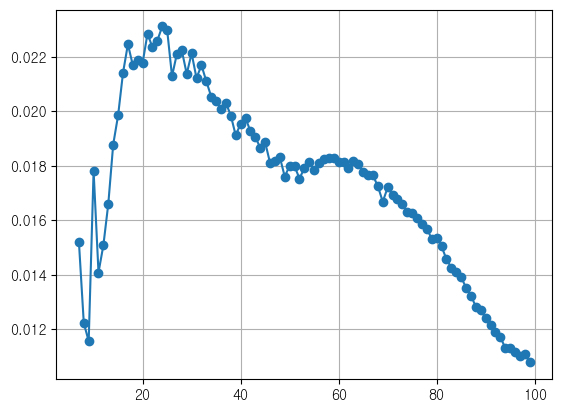

In [11]:
x = pd.DataFrame(mu, columns = ["week", "mu"])
plt.plot(x["week"], x["mu"], marker = 'o')
plt.grid(True)
plt.show()